# Collaboration and Competition

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from agent import Agent
import random, torch, time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from model import Actor, Critic
from torch.autograd import Variable
from torchviz import make_dot

%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="/home/psardar/DRLND/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

In [6]:


def ddpg(n_episodes=1500, max_t=2000):
        
    scores_window = deque(maxlen=100)
    scores = []
    total_time_elapsed = 0
    for i_episode in range(1, n_episodes+1):
        begin = time.time()
        avg_score = 0
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores_t = np.zeros(num_agents)                        # initialize the score (for each agent)
        agent.reset()
        score = 0
        for t_step in range(max_t):
            actions = agent.act(states)     
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished   
            agent.step(states, actions, rewards, next_states, dones, t_step)
            states = next_states
            scores_t += rewards
            if np.any(dones):
                break
        
        score = np.max(scores_t)
        scores_window.append(np.max(score))
        avg_score = np.mean(scores_window)
        scores.append(score)        
        
        end = time.time()
        diff = end - begin
        print("\rEpisode {:}\t Average Score {:.2f}\tTime {:.2f} s".format(i_episode, avg_score, diff), end="")
        total_time_elapsed += diff
        
        if i_episode % 100 == 0:
            print("\rEpisode {:}\t Average Score {:.2f}".format(i_episode, avg_score))

        if avg_score >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\t\tTime Elapsed {:.2f} s'.format(i_episode, avg_score,total_time_elapsed))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')            
            break
    return scores

Episode 100	 Average Score 0.01	Time 1.22 s
Episode 200	 Average Score 0.03	Time 1.22 s
Episode 300	 Average Score 0.11	Time 5.87 ss
Episode 357	 Average Score 0.51	Time 87.15 s
Environment solved in 357 episodes!	Average Score: 0.51		Time Elapsed 2222.97 s


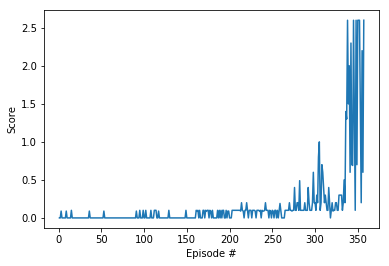

In [7]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
agent.actor_local.load_state_dict(torch.load('/home/psardar/DRLND/deep-reinforcement-learning/p3_collab-compet/checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('/home/psardar/DRLND/deep-reinforcement-learning/p3_collab-compet/checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(round(np.mean(scores),2)))

#env.close()

Total score (averaged over agents) this episode: 1.55


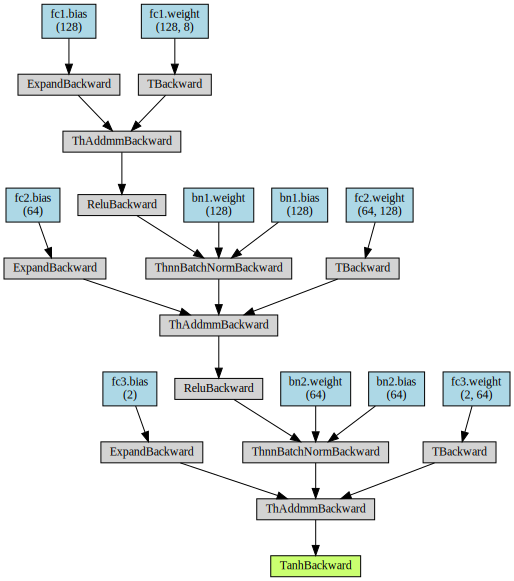

In [16]:
model = Actor(8, 2, 0)

x = Variable(torch.randn(8)).unsqueeze(0)
model.eval()
y = model(x)
             
make_dot(y, params=dict(list(model.named_parameters())))

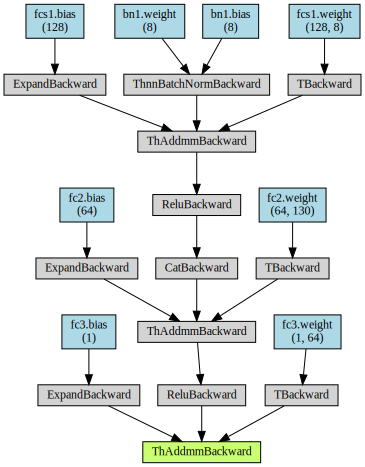

In [17]:
model = Critic(8, 2, 0)

x = Variable(torch.randn(8)).unsqueeze(0)
action = Variable(torch.randn(2)).unsqueeze(0)
model.eval()
y = model(x, action)
             
make_dot(y, params=dict(list(model.named_parameters())))